In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xbout
import xhermes

%load_ext autoreload
%autoreload 2
%matplotlib inline

print("Done")

Done


# Introduction
The purpose of this notebook is to go through the normalisations of the initial density function and domain dimensions in the Hermes-3 blob2d example.

Mike Kryjak 2023

# 0. Read the simulation

In [4]:
path = r"C:\Users\mikek\OneDrive\Project\neptune\blob2d"

### Read in the Hermes-3 result
- We will read it in twice.
- The first time we will use a bare xBOUT method to prevent any unscaling. This is called "ds" and has normalised units.
- The second time we will read it in using xHermes and call it "ds2". This one will have parameters in unscaled units.
- Note that due to various reasons we need to unscale geometry even in the xHermes case (see next section)

In [5]:
ds = xbout.open_boutdataset(
        datapath=os.path.join(path, "BOUT.dmp.*.nc"),
        inputfilepath=None,
        chunks={},
        run_name=None,
        info=False,
        keep_xboundaries = False,
        keep_yboundaries = False
    )

ds = ds.squeeze()    # Gets rid of empty dimensions


ds2 = xhermes.open(path, keep_xboundaries = False, keep_yboundaries = False)  
ds2 = ds2.squeeze()

C:\Users\mikek\OneDrive\Project\python-packages\xBOUT\xbout\geometries.py:226: UserWarning: Size of toroidal domain as calculated from nz*dz (<xarray.DataArray 'dz' ()>
dask.array<sub, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Attributes:
    cell_location:  CELL_CENTRE
    direction_y:    Standard
    direction_z:    Average
    source:         Coordinates
    metadata:       {'BOUT_VERSION': 5.0, 'Bnorm': 0.35, 'Cs0': 21884.7358940...
    options:        None
    geometry:        is not the same as 2pi*(ZMAX - ZMIN) (6.283185307179586): using value from dz
  warn(
C:\Users\mikek\OneDrive\Project\python-packages\xBOUT\xbout\geometries.py:226: UserWarning: Size of toroidal domain as calculated from nz*dz (<xarray.DataArray 'dz' ()>
dask.array<sub, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Attributes:
    cell_location:  CELL_CENTRE
    direction_y:    Standard
    direction_z:    Average
    source:         Coordinates
    metadata:       {'B

Ne already annotated
Vort already annotated
phi already annotated


# 1. Process the domain dimensions
- We are creating a grid of 256 x 1 x 256 points (260 x 1 x 256 with guard cells) spanning 0.05m by 0.05m
- Note that nz is periodic so there are no guard cells. See: https://bout-dev.readthedocs.io/en/latest/user_docs/input_grids.html
- BOUT++ uses a field aligned grid, so the grid spacing dx and dz will need to be in flux coordinates.
- dx = total radial width [m] * major radius [m] * Bpol [T] / (number of cells - number of guard cells)
- dz = total poloidal length [m] / major radius [m] / (number of cells)

From input file:

    [mesh]
    nx = 260
    ny = 1
    nz = 256

    Lrad = 0.05  # Radial width of domain [m]
    Lpol = 0.05  # Poloidal size of domain [m]

    Bpxy = 0.35  # Poloidal magnetic field [T]
    Rxy = 1.5   # Major radius [meters]

    dx = Lrad * Rxy * Bpxy / (nx - 4)  # Poloidal flux
    dz = Lpol / Rxy / nz   # Angle

### Recreating spatial dimensions from cell widhs
- You will find that xBOUT will read the "z" coordinate correctly, but it will read "x" as just index values. 
- Here is the reasoning from the xBOUT examples (https://github.com/boutproject/xBOUT-examples/blob/master/blob2d/blob2d_example.ipynb):
> "We choose to create a 'coordinate' for the x-dimension from dx. This is not done generically because dx can have two-dimensional dependence - as well as varying radially it can be different e.g. in core and PF regions. However, for a slab geometry like blob2d, dx is a constant so it can easily be used to create a one-dimensional x-coordinate. This ensures we get a sensible aspect ratio in plots. A z-coordinate was already created from dz, because dz is always a scalar, so it can always be used to create a 1d 'dimension coordinate'."
- BOUT++ supports so many different types of applications that it's always a good idea to check the coordinates against the dx/dy/dz, which are the "ground truth" of what the code is solving.



### Unscaling the geometry
- First let's make sure we are operating on dx and dz that have the units of metres.
- Since the grid has been defined in the input file, we must unscale it.
    
    dx = Lrad * Rxy * Bpxy / (nx - 4)  # Poloidal flux
    
    dz = Lpol / Rxy / nz   # Angle


In [54]:
# From the input file:
Lrad = 0.05  # Radial width of domain [m]
Lpol = 0.05  # Poloidal size of domain [m]

Bpxy = 0.35  # Poloidal magnetic field [T]
Rxy = 1.5   # Major radius [meters]

new_dx = ds.coords["dx"] / (Rxy * Bpxy)
new_dz = ds.coords["dz"] * (Rxy)

print(f"The sum of new_dx is {new_dx.sum():.2e} [m].")
print(f"The sum of new_dz is {new_dz.sum():.2e} [m].")

The sum of new_dx is 5.00e-02 [m].
The sum of new_dz is 5.00e-02 [m].


- Now that we have cell widths in metres, let's construct the axes.
- We have a uniform grid, so we can assign new coordinates to the dataset based on the new cell width we calculated.

Text(0.5, 1.0, 'Density plot with X and Y axis in flux coordinates')

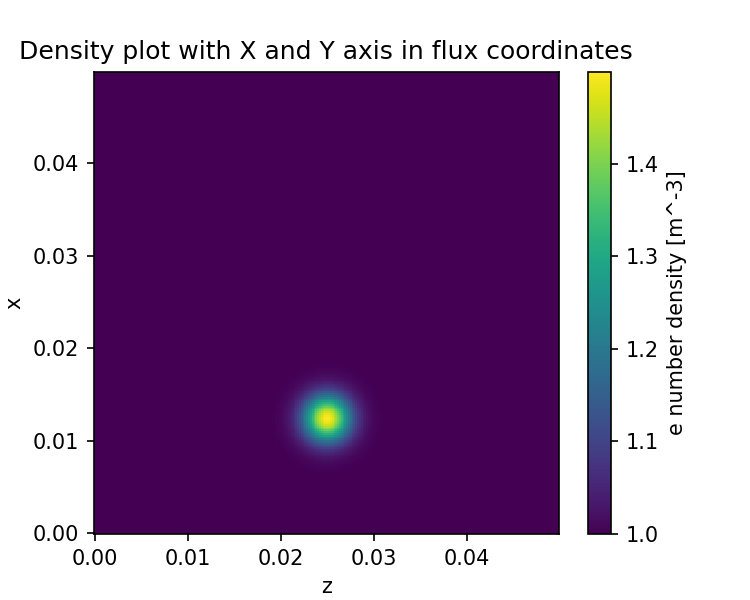

In [65]:
# Based on https://github.com/boutproject/xBOUT-examples/blob/master/blob2d/blob2d_example.ipynb

ds = ds.assign_coords(x = np.arange(ds.sizes["x"]) * new_dx[0].values)
ds2 = ds2.assign_coords(x = np.arange(ds2.sizes["x"]) * new_dx[0].values)

ds = ds.assign_coords(z = np.arange(ds.sizes["z"]) * new_dz[0].values)
ds2 = ds2.assign_coords(z = np.arange(ds2.sizes["z"]) * new_dz[0].values)

ds.coords["x"]["unit"] = "m"

fig, ax = plt.subplots(figsize = (5,4), dpi = 150)
ds["Ne"].isel(t=0).plot(ax = ax)
ax.set_title("Density plot with X and Y axis in metres")

# 1. Reproduce what the input file function is doing
- To understand how the initial Ne field is created, let's reproduce the function that defines it in this notebook and compare to what the code is showing in normalised units at the 0th timestep.


### Input file geometry convention
- The input file has its own convention for referring to geometry. It's a BOUT++ thing. See https://bout-dev.readthedocs.io/en/latest/user_docs/variable_init.html#expressions
- We have to reconstruct it if we are to reproduce some input file function.
- From Ben:
>"In the input “x” is a radial coordinate between 0 and 1, linear in grid cell number; “y” is a parallel coordinate between 0 and 2pi, linear in grid cell number; “z” is a binormal coordinate between 0 and 2pi, also linear in grid cell number.
The 2pi factors are purely a convention, for historical reasons because BOUT++ was developed for toroidal coordinates in which y and z are angle-like. In hindsight this was probably a mistake, but we’re stuck with it now."

##### Note
- You only really need to do this kind of stuff if you are trying to reconstruct something in the input file.

In [68]:
xnorm = ds2.coords["x"].values.max()                   # X: radial coordinate, 0-1
ynorm = ds2.coords["y"].values.max() / (2 * np.pi)     # Y: Parallel coordinate, 0-2pi
znorm = ds2.coords["z"].values.max() / (2 * np.pi)     # Z: Binormal coordinate, 0-2pi

ds2.coords["xnorm"] = ds2.coords["x"] / xnorm
ds2.coords["ynorm"] = ds2.coords["y"] / ynorm
ds2.coords["znorm"] = ds2.coords["z"] / znorm

ds.coords["xnorm"] = ds.coords["x"] / xnorm 
ds.coords["ynorm"] = ds.coords["y"] / ynorm
ds.coords["znorm"] = ds.coords["z"] / znorm

### Reproduce the initial Ne field
- Lift the density initialisation function from the input file and replicate it in Python.
- Using xr.apply_ufunc, which creates a new data array based on an arbitrary function with coordinates as input. 
- You can see that the match is perfect.

Text(0.5, 1.0, 'Reproduced initialisation function')

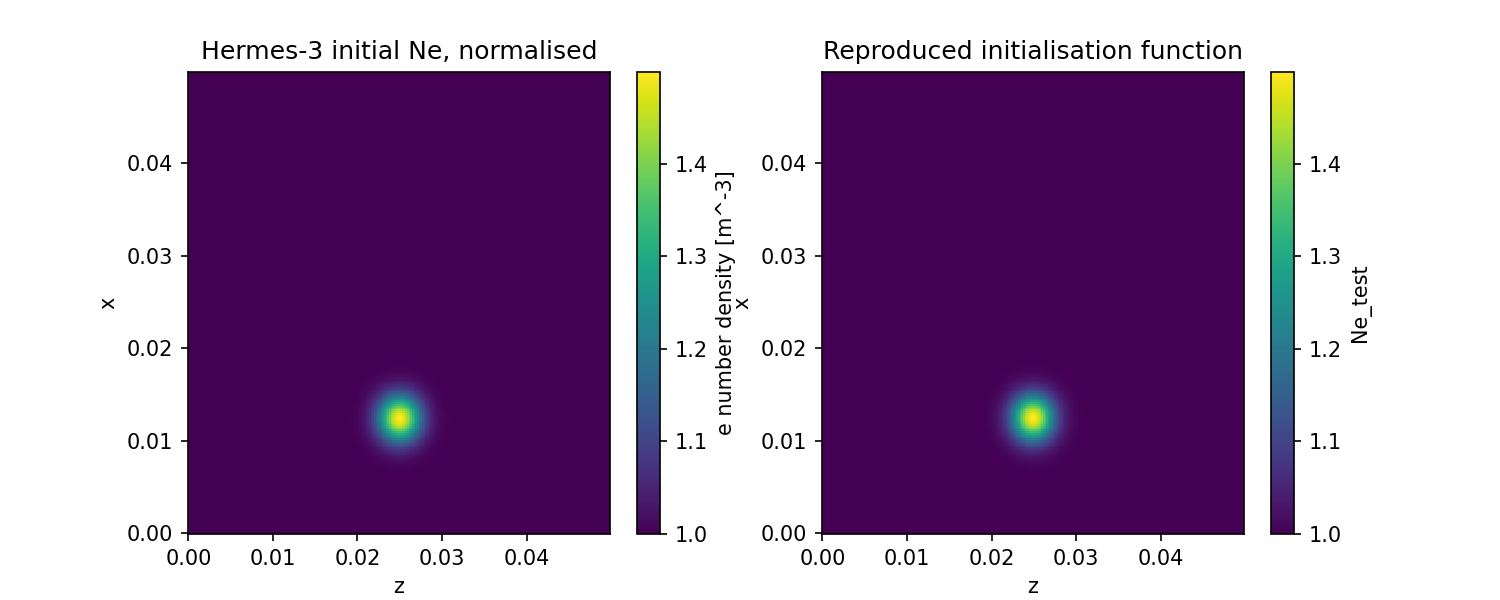

In [69]:
# From the input file:
height = 0.5    # In normalised density units
width = 0.05    # Fraction of radial/binormal (X/Y) domain size

# Function to provide density lifted verbatim from the input file
def f(x, z):
    return 1 + height * np.exp(-((x-0.25)/width)**2 - ((z/(2*np.pi) - 0.5)/width)**2)

ds["Ne_test"] = xr.apply_ufunc(f, ds.coords["xnorm"], ds.coords["znorm"])

fig, axes = plt.subplots(1,2, figsize = (10,4), dpi = 150)
ds["Ne"].isel(t=0).plot(ax = axes[0])   # Must select t=0 as the dataset has all timesteps.
ds["Ne_test"].plot(ax = axes[1])

axes[0].set_title("Hermes-3 initial Ne, normalised")
axes[-1].set_title("Reproduced initialisation function")

### Visualise the actual Maxwellian
- Two settings: height and width
- Height was 0.5. This refers to height above the background, which is 1 normalised unit, i.e. 1 x Nnorm.
- This makes the peak 0.5 + 1.0 = 1.5.
- Width was 0.0025, or 5% of the square 0.05m x 0.05m domain.
- And so you can see a Gaussian with a peak of 1.5 and a FWHM of about 0.0025. (note I haven't checked the width quantitatively here)

5% of the domain is 0.0024902343750000003


Text(0.5, 1.0, 'Initial density contour')

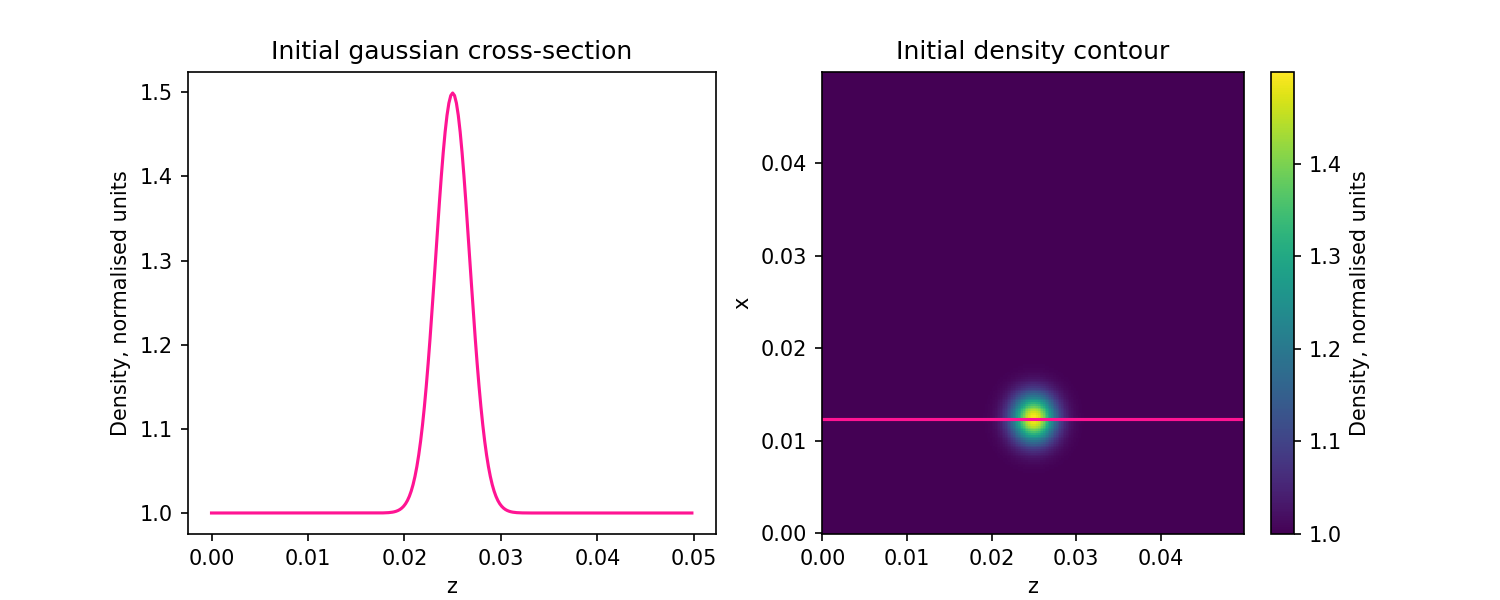

In [88]:
print(f'5% of the domain is {ds.coords["z"].values.max() * 0.05}')

peak_coords = ds["Ne"].isel(t=0).argmax(dim = ("x", "z"))
peak_x = peak_coords["x"].values
peak_z = peak_coords["z"].values

fig, axes = plt.subplots(1,2, figsize = (10,4), dpi = 150)

# Line plot showing cross-section through initial gaussian
ds["Ne"].isel(t=0).isel(x = peak_x).plot(ax = axes[0], color = "deeppink")

# 2D plot showing the cross-section line
ds["Ne"].isel(t=0).plot(ax = axes[1], cbar_kwargs={'label': "Density, normalised units"})
axes[1].plot(ds.coords["z"], np.ones_like(ds.coords["z"]) * ds.coords["x"][peak_x].values, color = "deeppink")


axes[0].set_title("Initial gaussian cross-section")
axes[0].set_ylabel("Density, normalised units")   # xBOUT will annotate with SI units whether the data is unscaled or not.
axes[1].set_title("Initial density contour")

# 2. Represent the initialisation function in terms of real dimensions

### Reproduce the unscaled initial density field
- Let's see what it takes to reproduce the result but with specifying the density in SI units.
- The first setting is the height. Let's take the maximum initial density in Hermes-3 to get the needed peak in [m-3].
- The second setting is the width. This is in % of the domain width, and so unitless. Let's keep it like this. 
- We need to modify the initialisation function to normalise these internally.

The maximum density was 3.00e+18 [m-3]
The background was 2.00e+18 [m-3]
So the gaussian height is 9.98e+17 [m-3]


Text(0.5, 1.0, 'Reproduced initialisation function')

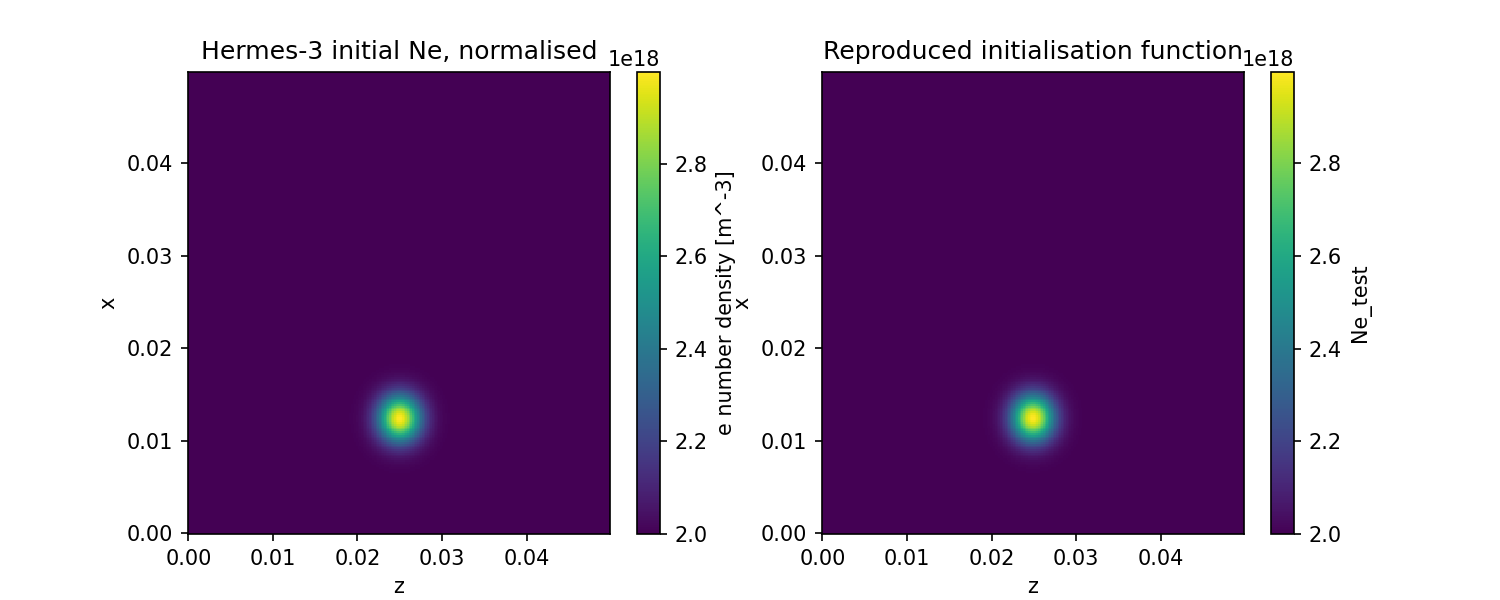

In [90]:
Nnorm = ds.metadata["Nnorm"]    # Density normalisation factor

desired_maximum_density_SI = ds2["Ne"].values.max()
height_SI = desired_maximum_density_SI - Nnorm    # Background was set to 1 Nnorm.
width = 0.05    # Unit independent as it's a fraction

print(f"The maximum density was {desired_maximum_density_SI:.2e} [m-3]")
print(f"The background was {Nnorm:.2e} [m-3]")
print(f"So the gaussian height is {height_SI:.2e} [m-3]")

# This time the function needs to accept the X and Z in their unscaled units, so it must normalise things inside.
def f(x, z):
    
    height = height_SI / Nnorm   # Internally normalise gaussian height
    x = x / xnorm    # Internally normalise X
    z = z / znorm    # Internally normalise Z
    out = 1 + height * np.exp(-((x-0.25)/width)**2 - ((z/(2*np.pi) - 0.5)/width)**2)    # With X and Z normalised, this should be exactly the same as before
    out = out * Nnorm   # This time we want to have density in SI units, so we must unscale the result
    
    return out

ds2["Ne_test"] = xr.apply_ufunc(f, ds2.coords["x"], ds2.coords["z"])   # Apply to the unscaled units in their correct units.

fig, axes = plt.subplots(1,2, figsize = (10,4), dpi = 150)
ds2["Ne"].isel(t=0).plot(ax = axes[0])   # Must select t=0 as the dataset has all timesteps.
ds2["Ne_test"].plot(ax = axes[1])

axes[0].set_title("Hermes-3 initial Ne, normalised")
axes[-1].set_title("Reproduced initialisation function")

# 3. Square the circle: use the function to specify an alternate gaussian, all in SI units
- To make it abundantly clear how all of this works, let's play with the function and create a different kind of gaussian.
- By comparing the function to a regular Gaussian expression, we can see that it also contains parameters for the X and Z position.

Text(0.5, 1.0, 'Central position, FWHM = 20% of domain, peak=2e20')

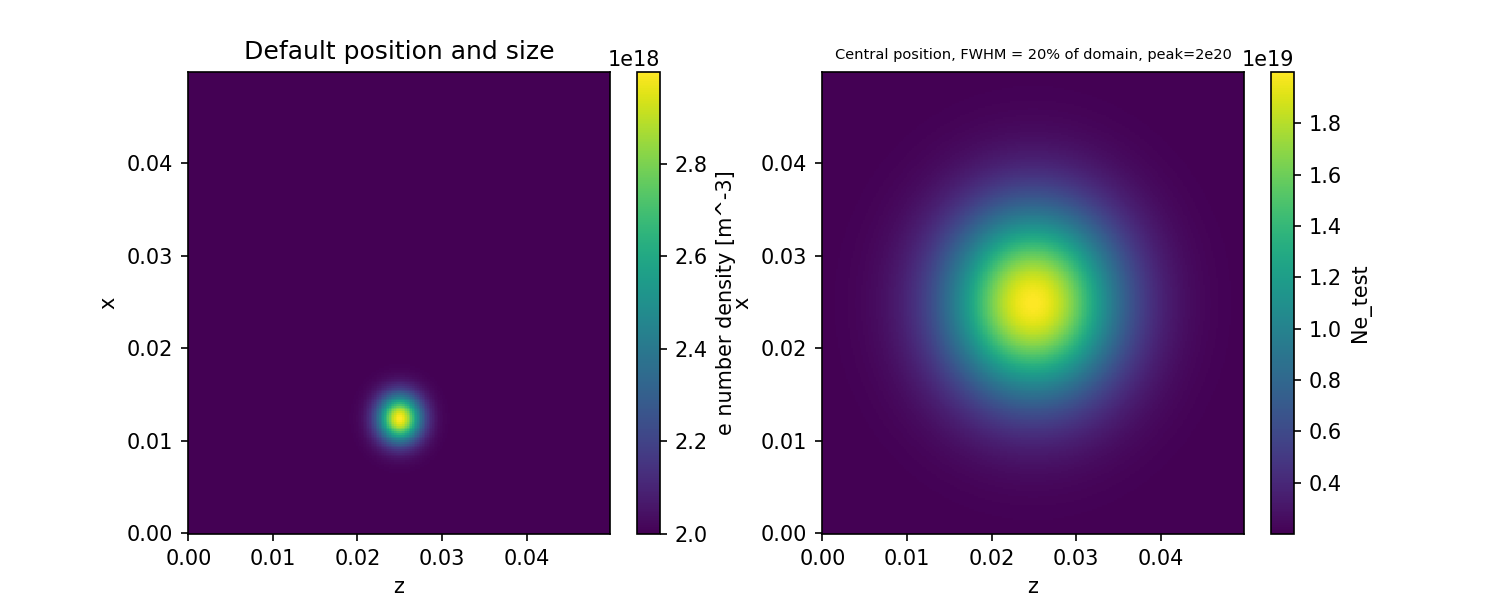

In [98]:
desired_maximum_density_SI = 2e19   # [m-3]
height_SI = desired_maximum_density_SI - Nnorm    # Height of gaussian above background
width = 0.2   # Fraction of length (N.B: domain is square)
x_position = 0.5   # in percentile along axis
z_position = 0.5    # in percentile along axis


def f(x, z):
    
    height = height_SI / Nnorm
    x = x / xnorm
    z = z / znorm
    
    out = 1 + height * np.exp(-((x-x_position)/width)**2 - ((z/(2*np.pi) - z_position)/width)**2)   
    out = out * Nnorm  
    
    return out

ds2["Ne_test"] = xr.apply_ufunc(f, ds2.coords["x"], ds2.coords["z"])   

fig, axes = plt.subplots(1,2, figsize = (10,4), dpi = 150)
ds2["Ne"].isel(t=0).plot(ax = axes[0])   
ds2["Ne_test"].plot(ax = axes[1])

axes[0].set_title("Default position and size")
axes[-1].set_title("Central position, FWHM = 20% of domain, peak=2e20", fontsize = 7)